# Viewing Segmentations

Attempt to view the segmentation mask for qualitative evaluation across the 5 classes 
required for this problem. Locations for each should be specified in a list so that it is 
easily extensible. The function will be specific enough as to specify the location of the 
prediction, and the slice.

Given a folder with raw data, the ground truth segmentations also supply a dictionary of
file locations with other model predictions 

In [12]:
import os, sys
dir1 = os.path.dirname(os.path.abspath(''))
if not dir1 in sys.path: sys.path.append(dir1)

In [13]:
from utils.environment import setup_data_vars

In [37]:
import matplotlib.pyplot as plt
from matplotlib import transforms
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
import os
import re
import itertools
import shutil

def plot_segmentations(raw_data_path: str
                       , ground_truth_path: str
                       , slice_default: int
                       , predictions_path: dict
                       , manual_slice: dict = None
                       , subset: set = None
                       , segmentation_axis: int = 1
                       , save_report = True
                       ):
    """Generates a grid of each example class and the ground truth with the optional list
    of predictions

    Args:
        raw_data_path (str): path to the raw unlablled CT scans 

        ground_truth_path (str): path to the ground truth segmentations provided by
        clinicians 

        slice_default (int): default slice dimension to take (for now, assume it is the z
        dimension). May throw an error if the z dimension is out of range.

        predictions_path (List[str]): a list of paths that point to a list of predicted
        segmentations that other models have predicted 

        manual_slice (dict, optional): Allows for a manual slice dimension for a certain
        slice, e.g. if the default slice given to others is not descriptive enough.
        Defaults to None.

        subset (set, optional): A subset of the data to display. Defaults to None.

        segementation_axis (int, optional): Along which axis to slice data. Defaults to 1.

        save_report (bool, optional): Whether to save the report or just show. Defaults to
        True
    """

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Before proceeding, check that the arguments are valid >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    assert os.path.isdir(raw_data_path),\
          f"{raw_data_path} is not a valid directory for Raw Data"
    assert os.path.isdir(ground_truth_path),\
          f"{ground_truth_path} is not a valid directory for Ground Truth labels"
    for p in predictions_path.values(): assert os.path.isdir(p),\
          f"{p} is not a valid directory for additional Predictions"

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Define the helper plotting functions >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    def get_slice_for_image_path(image_path):
        image_id = get_id_from_path(image_path)

        # Define the slices for each axis
        slices = [slice(None)] * 3      # Create a list of slice(None) for all dimensions
        img_slice = manual_slice[image_id] if image_id in manual_slice.keys() else slice_default
        slices[segmentation_axis] = img_slice # The selected axis is given by the variable `axis`

        return slices
    
    def get_id_from_path(path, needs_num=True):
        # Assume that it is the full path that points to the file name. The file name
        # should contain a number indicating the id number. It should appear first
        numbers = re.findall('\d+', path.split('/')[-1])
        if needs_num and len(numbers) == 0:
            raise ValueError(f"Could not find a number in {path}")
        if not needs_num and len(numbers) == 0:
            return 0
        return int(numbers[0])

    def plot_base_image(image_path, i, axes, slices):
        # Read image into numpy array
        image = sitk.ReadImage(image_path)
        array_image = sitk.GetArrayFromImage(image)

        # Plot the image into each column
        for j in range(2 + len(predictions_path)):
            axes[i, j].imshow(array_image[tuple(slices)], cmap='gray')
    
    def plot_segmentation(seg_path, i, j, slices):
        # Read image into numpy array
        gt_label = sitk.ReadImage(seg_path)
        array_gt_label = sitk.GetArrayFromImage(gt_label)
        
        # Set transparent background for non-segmented areas
        alpha_mask = np.where(array_gt_label[tuple(slices)] > 0, 1, 0).astype(np.float32)
        axes[i, j].imshow(array_gt_label[tuple(slices)], alpha=alpha_mask, cmap='viridis')

    def format_chart(axes, column_titles, image_paths):
        # Remove ticks and invert y axis
        for i in range(nrows):
            for ax in axes[i,]:
                ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
                if segmentation_axis == 1:
                    ax.invert_yaxis()
                if segmentation_axis == 2:
                    # TODO: Translate the data with .T
                    pass

        # Set titles for each column
        for ax, title in zip(axes[0], column_titles):
            ax.set_title(title)

        # Set y labels for each row
        for ax, title in zip(axes[:,0], image_paths):
            id = get_id_from_path(title)
            slices = get_slice_for_image_path(title)
            ax.set_ylabel(f'Sample {id} (axis {segmentation_axis}={slices[segmentation_axis]})')

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Obtain requested image paths >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    image_paths = [
        os.path.join(raw_data_path, fn) 
        for fn in sorted(os.listdir(raw_data_path)) 
        if (fn.endswith('.nii.gz')) and (True if subset is None else get_id_from_path(fn) in subset)
    ]
    

    gt_paths = [
        os.path.join(ground_truth_path, fn)
        for fn in sorted(os.listdir(ground_truth_path))
        if (fn.endswith('.nii.gz')) and (True if subset is None else get_id_from_path(fn) in subset)
    ]

    predicted_samples = [
        [
            os.path.join(prediction, fn) 
            for fn in sorted(os.listdir(prediction)) 
            if (fn.endswith('.nii.gz')) and (True if subset is None else get_id_from_path(fn) in subset)
        ] 
        for prediction in predictions_path.values()]

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Plot the data >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    # Define the dimensions of the plot
    ncols = 2 + len(predictions_path)
    nrows = len(subset) if subset != None else len([fn.endswith('.nii.gz') for fn in os.listdir(raw_data_path)])

    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 5, nrows * 2.5))

    # For each patient example plot the raw data, ground truth and predictions
    for i, (img, gt, pred) in tqdm(enumerate(itertools.zip_longest(image_paths, gt_paths, [*itertools.zip_longest(*predicted_samples)]))):

        # TODO: change function to display the most problematic z-slice based on a given evaluation metric
        slices = get_slice_for_image_path(img)

        # Plot the base image  
        plot_base_image(img, i, axes, slices)

        # Plot the ground truth segmentation
        plot_segmentation(gt, i, 1, slices)

        # Plot the predictions
        for j, p in enumerate(pred):
            if p is not None:
                plot_segmentation(p, i, j + 2, slices)
            else:
                axes[i, j + 2].cla()

    # Format the axis
    format_chart(axes, column_titles=['Raw Data', 'Ground Truth'] + list(predictions_path.keys()), image_paths=image_paths)        

    # Display summary plots
    organ_class = ground_truth_path.split("/")[-2][11:]

    number = max([0] + [get_id_from_path(fn, False) for fn in os.listdir('reports/') if fn.startswith(f'report{organ_class}')])
    plt.suptitle(f"Segmentation for class {organ_class} (Report {number + 1})")

    if save_report:

        # << Saving the Figure >>

        file_name = lambda num: f'report{organ_class}_{num}.png'

        try:
            os.makedirs('reports/old', exist_ok=True)
            shutil.move(f'reports/{file_name(number)}', f'reports/old/')
            plt.savefig(f'reports/{file_name(number + 1)}', bbox_inches='tight')
        except FileNotFoundError as e:
            print(f'WARNING: {e}')

    else:
        plt.show()

In [38]:
from typing import List


def draw_segmentations(class_id: int, subset: List[int] = None, axis = 1, save=True):
    """Prints a plot of the segmentations for the given class in the predefined format.
    This method acts in a factory pattern to generate the plot for each class. 

    Args:
        class_id (int): 1: Anorectum ... 5: Parametrium 
        
        subset (List[int], optional): A subset of the data to display. If None draws all.
        Defaults to None.

        axis (int, optional): The axis to slice the data. Defaults to 1.

        save (bool, optional): Whether to save the report. Defaults to True.
    """

    setup_data_vars()

    classes = [os.environ.get('Anorectum')
             , os.environ.get('Bladder')
             , os.environ.get('CTVn')
             , os.environ.get('CTVp')
             , os.environ.get('Parametrium')
             , os.environ.get('Uterus')
             , os.environ.get('Vagina')]

    raw_data = [os.path.join(os.environ.get('nnUNet_raw'), x, os.environ.get('data_trainingImages')) for x in classes]
    gt_labels = [os.path.join(os.environ.get('nnUNet_raw'), x, os.environ.get('data_trainingLabels')) for x in classes]

    anorectum = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Anorectum'), 'imagesTr_3dhighres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Anorectum'), 'nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres'),
    }

    bladder = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Bladder'), 'imagesTr_3dhighres'),
        'total segmentator': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Bladder'), 'imagesTs')
    }

    ctvn = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('CTVn'), 'imagesTr_3dhighres'),
    }

    ctvp = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('CTVp'), 'imagesTr_3dhighres'),
    }

    parametrium = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Parametrium'), 'imagesTr_3dhighres'),
    }

    uterus = {
        # TODO: nnUNet 
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Uterus'), 'imagesTr_3dhighres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Uterus'), 'nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres'),
    }

    vagina = {
        # TODO: nnUNet
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Vagina'), 'nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres'),
    }

    predictions = [anorectum, bladder, ctvn, ctvp, parametrium, uterus, vagina]
    slice_axes_per_class = [
        [
            (90, {}),
            (300, {4: 280, 6: 290, 100: 280}),
            (250, {})
        ], [
            (90, {}),
            (240, {}),
            (250, {})
        ], [
            (90, {}),
            (250, {}),
            (250, {})
        ], [
            (90, {}),
            (275, {}),
            (250, {})
        ], [
            (90, {}),
            (265, {}),
            (250, {})
        ], [
            (90, {}),
            (265, {}),
            (250, {})
        ], [
            (90, {}),
            (255, {}),
            (250, {})
        ]
    ]

    if 1 <= class_id <= len(predictions):
        index = class_id - 1
        slices = slice_axes_per_class[index][axis]
        plot_segmentations(raw_data_path=raw_data[index]
                           , ground_truth_path=gt_labels[index]
                           , slice_default=slices[0]
                           , predictions_path=predictions[index]
                           , manual_slice=slices[1]
                           , subset=subset
                           , segmentation_axis=axis
                           , save_report=save)
    else:
        raise ValueError("Invalid class_id. Please choose a class between 1 and 5.")

# Plotting

3it [00:02,  1.10it/s]


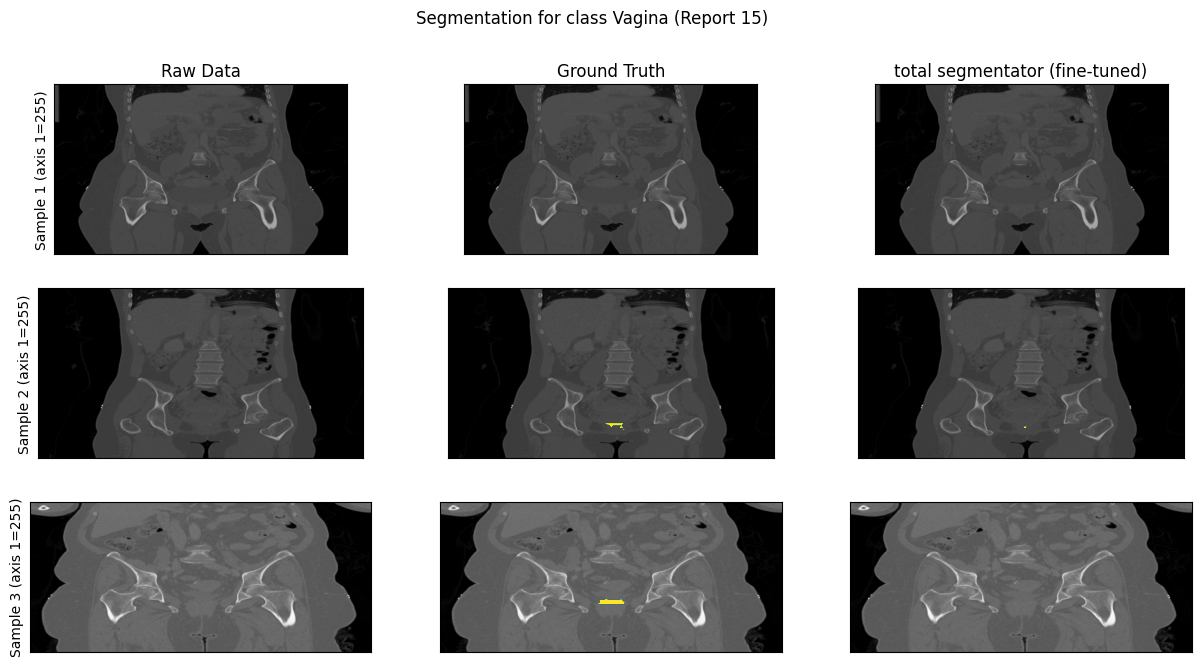

In [39]:
# draw_segmentations(class_id=2) #,  subset=[1,2,3,4,5,6,7])
# draw_segmentations(class_id=5,  subset=[1,2]) #,3,4,5,6,7])

# for i in range(1, 8):
#     draw_segmentations(class_id=i)

# draw_segmentations(class_id=7, subset=[1, 100], axis=1, save = False)
draw_segmentations(class_id=7, subset=[1,2,3], axis=1, save = True)
# draw_segmentations(class_id=1, axis=0, save = False)